## Set-up

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from helpers import output_to_file,Item

In [4]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


## Example image

In [5]:
image = cv2.imread('images/dog.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
items=[]
items.append(Item("image",image,"TensorInt"))

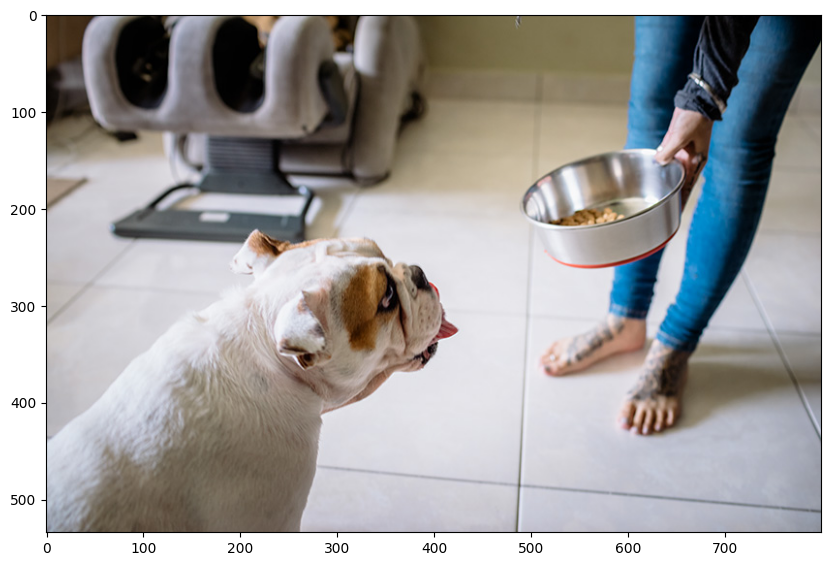

In [6]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

## Selecting objects with SAM

First, load the SAM model and predictor. Change the path below to point to the SAM checkpoint. Running on CUDA and using the default model are recommended for best results.

In [7]:
from segment_anything import  SamPredictor
from segment_anything.build_sam import sam_model_registry
import torch

checkpoint = "sam-convert/sam_vit_b_01ec64.pth"
sam =sam_model_registry["vit_b"](checkpoint)

sam.to()
predictor = SamPredictor(sam)

In [8]:
predictor.set_image(image)

In [9]:
input_point = np.array([[170, 375]])
input_label = np.array([1]).astype(np.int64)
items.append(Item("input_point",torch.from_numpy(input_point),"TensorInt"))
items.append(Item("input_label",torch.from_numpy(input_label),"TensorInt"))


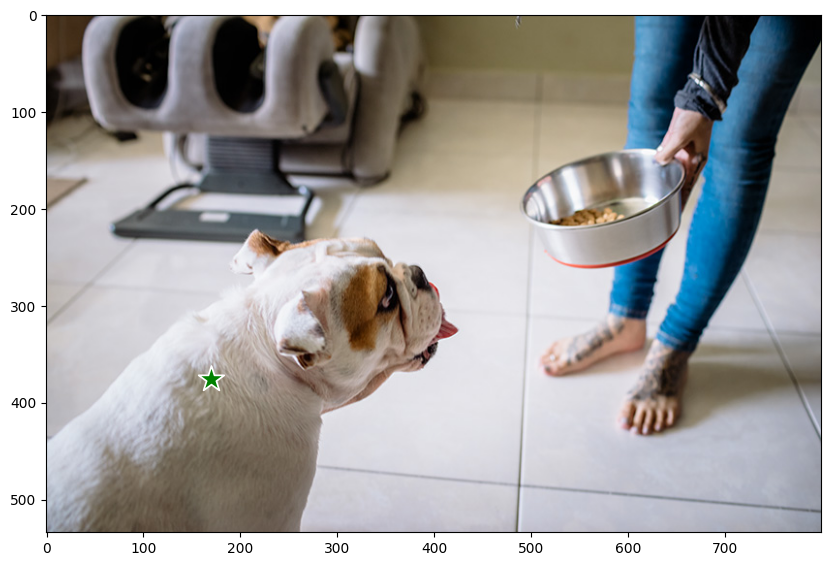

In [10]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

In [11]:
masks, scores, logits,mask_values = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)
items.append(Item("mask_values",torch.from_numpy(mask_values),"TensorFloat"))
items.append(Item("masks",torch.from_numpy(masks),"TensorBool"))
items.append(Item("scores",torch.from_numpy(scores),"TensorFloat"))
items.append(Item("logits",torch.from_numpy(logits),"TensorFloat"))
output_to_file("prediction",items)


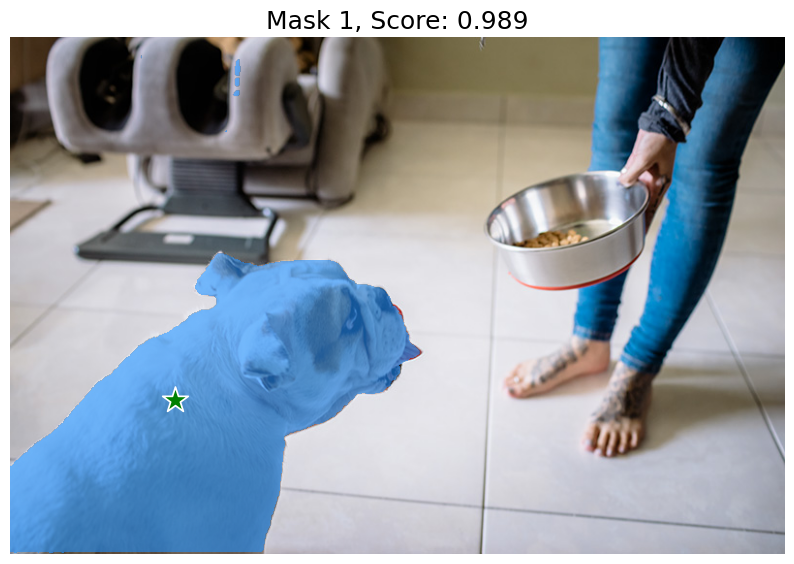

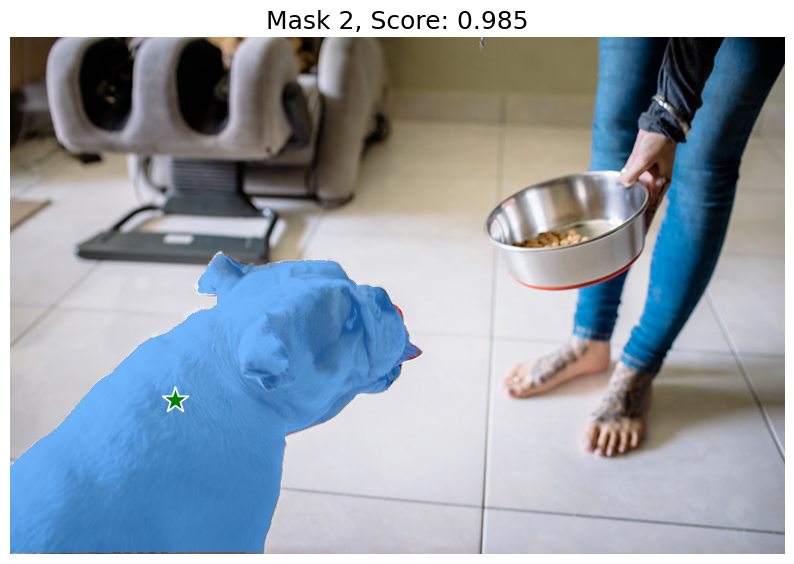

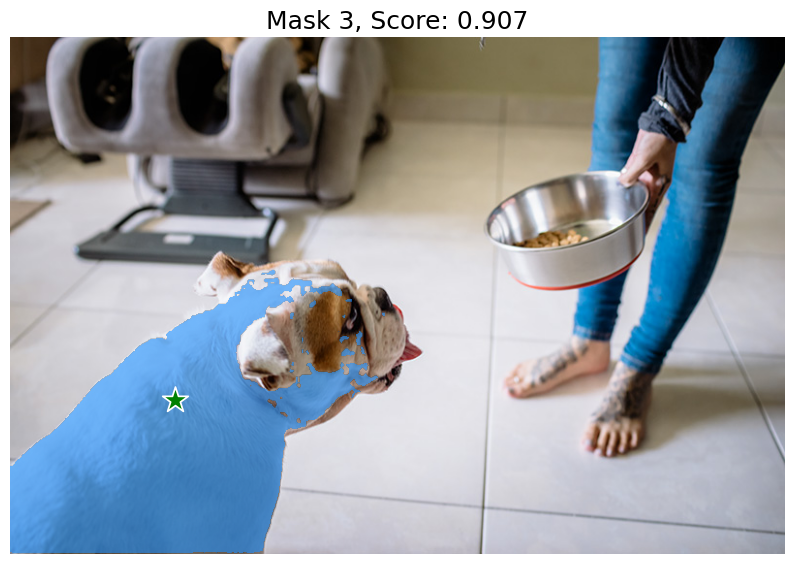

In [12]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  
  